### test GTP

### 1) Use package as standalone

Test with single emission


| date | amount | flow | activity |
|-------|-------|------|----------|
| 15-12-2020   | 10    | 1 (CO2)   | 2        |


In [1]:
import pandas as pd
import numpy as np

# defining a dummy dynamic inventory from above
dynamic_inventory_df = pd.DataFrame(
        data={
            "date": pd.Series(
                data=[
                    "15-12-2020",
                ],
                dtype="datetime64[s]",
            ),
            "amount": pd.Series(data=[1, ], dtype="float64"),
            "flow": pd.Series(data=[1, ], dtype="int"),
            "activity": pd.Series(data=[2,], dtype="int"),
        }
    )

In [2]:
dynamic_inventory_df

,date,amount,flow,activity
0,2020-12-15,1.0,1,2


In [3]:
from dynamic_characterization import characterize
from dynamic_characterization.ipcc_ar6 import characterize_co2, characterize_ch4, characterize_n2o

df_agtp = characterize(
        dynamic_inventory_df,
        metric="AGTP", # could also be GWP
        characterization_function_dict={
            1: characterize_co2,
            2: characterize_ch4,
            3: characterize_n2o,
        },
        time_horizon=100, #years
    )
    
df_agtp.amount.sum()

5.604504479321537e-16

<Axes: title={'center': 'AGTP'}, xlabel='date', ylabel='amount'>

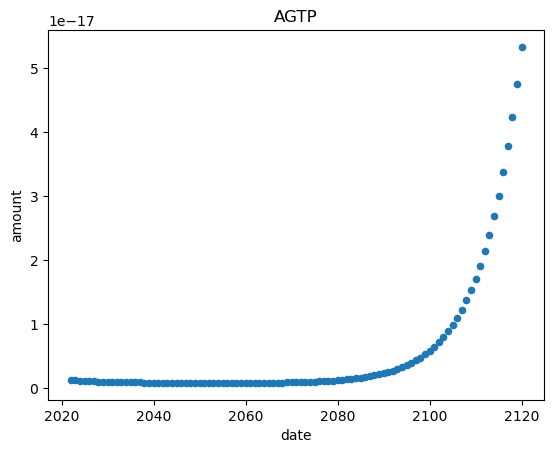

In [4]:
df_agtp.plot(x="date", y="amount", kind="scatter", title="AGTP") # i don't think this is correct

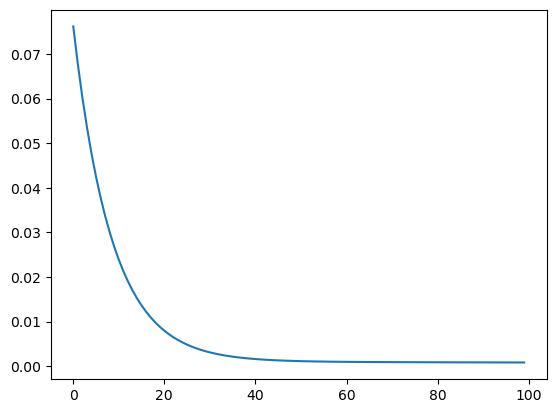

In [5]:
from dynamic_characterization.ipcc_ar6.agtp import IRF_temperature
IRF_temp =np.array([ IRF_temperature(year) for year in range(100) ])
import matplotlib.pyplot as plt
plt.plot(IRF_temp) #IRF_temperature seems correct

In [6]:
df_radiative = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        characterization_function_dict={
            1: characterize_co2,
            2: characterize_ch4,
            3: characterize_n2o,
        },
        time_horizon=101, #years
    )
rad_array = np.array(df_radiative["amount"])


6.078615207581017e-14


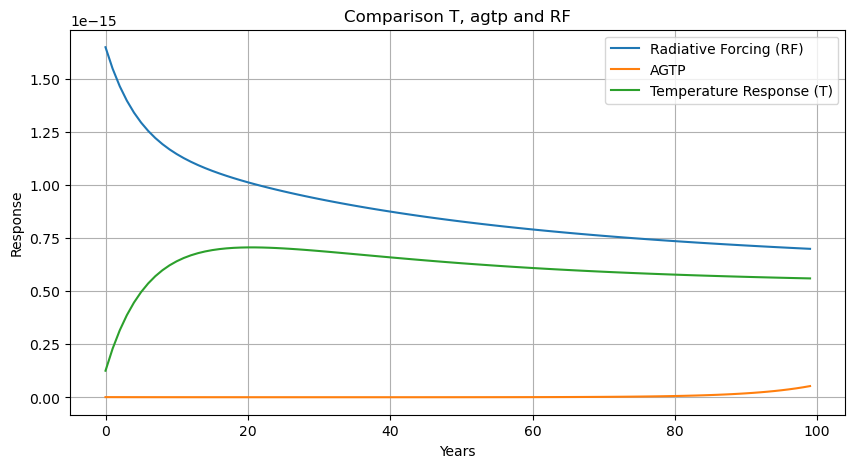

5.597176231027901e-16


In [7]:
import numpy as np
import matplotlib.pyplot as plt
RF = rad_array
IRF = IRF_temp

years = np.arange(0, 100, 1)  # Time in years

agtp = np.multiply(RF, IRF[::-1])
T = np.convolve(RF, IRF, mode="full")[:len(RF)]  # Convolution of RF and IRF, until time horizon -> correct, validated with CCI-tool, see screenshots below
cumsum = np.sum(T)  # Cumulative sum of the convolution result
print(cumsum)
# Time axis for the result (length of the convolution result)
T_years = np.arange(0, len(T), 1)

plt.figure(figsize=(10, 5))
plt.plot(years[:len(RF)], RF, label='Radiative Forcing (RF)')
plt.plot(years[:len(IRF)], agtp, label='AGTP')
plt.plot(T_years, T, label='Temperature Response (T)')
plt.xlabel('Years')
plt.ylabel('Response')
plt.title('Comparison T, agtp and RF')
plt.legend()
plt.grid()
plt.show()

test = (RF * IRF[::-1]).sum()
print(test)

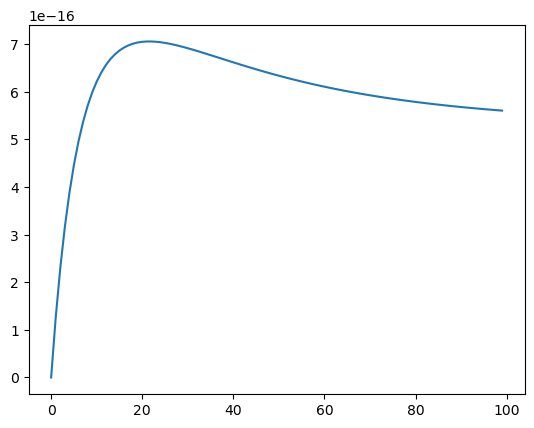

In [11]:
from dynamic_characterization import characterize_global_mean_temperature_change

mean_temperature_change = characterize_global_mean_temperature_change(
        characterization_function_dict={
            1: characterize_co2},
        row = dynamic_inventory_df.iloc[0],
        time_horizon=100,) #years)


import matplotlib.pyplot as plt

plt.plot(mean_temperature_change.amount)


Very similar to CCI tool output: 
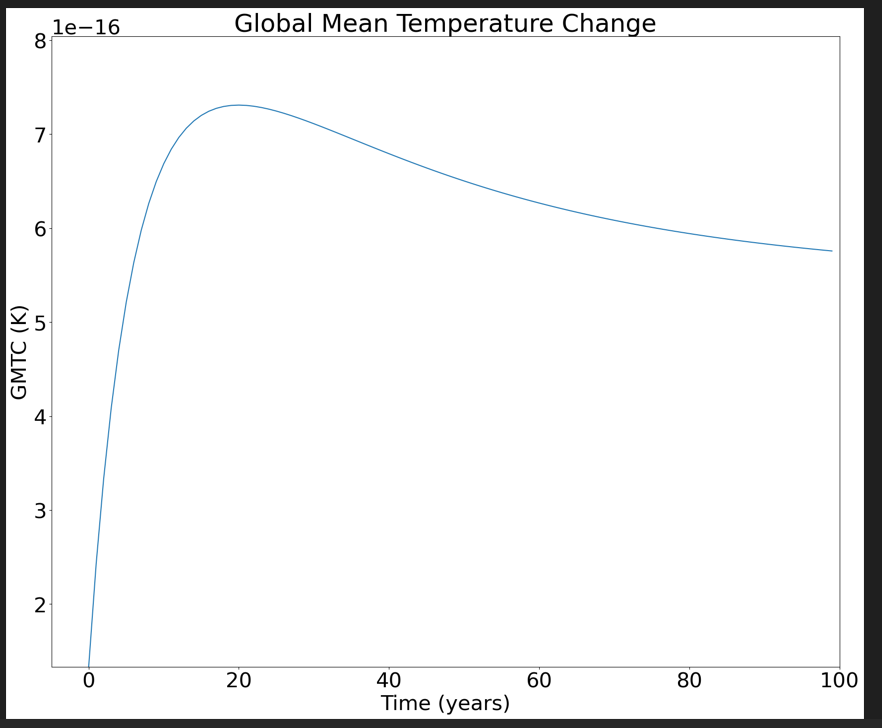

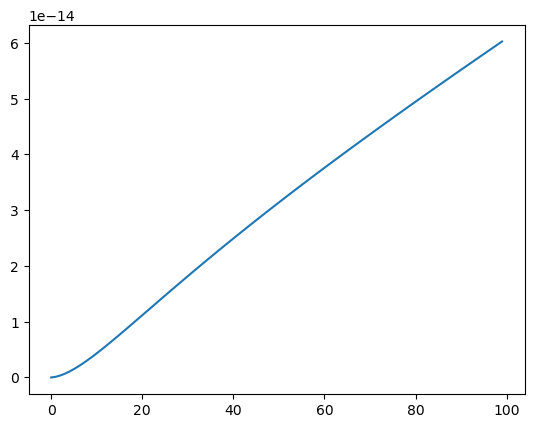

In [12]:
plt.plot(mean_temperature_change.amount.cumsum())

Also similar: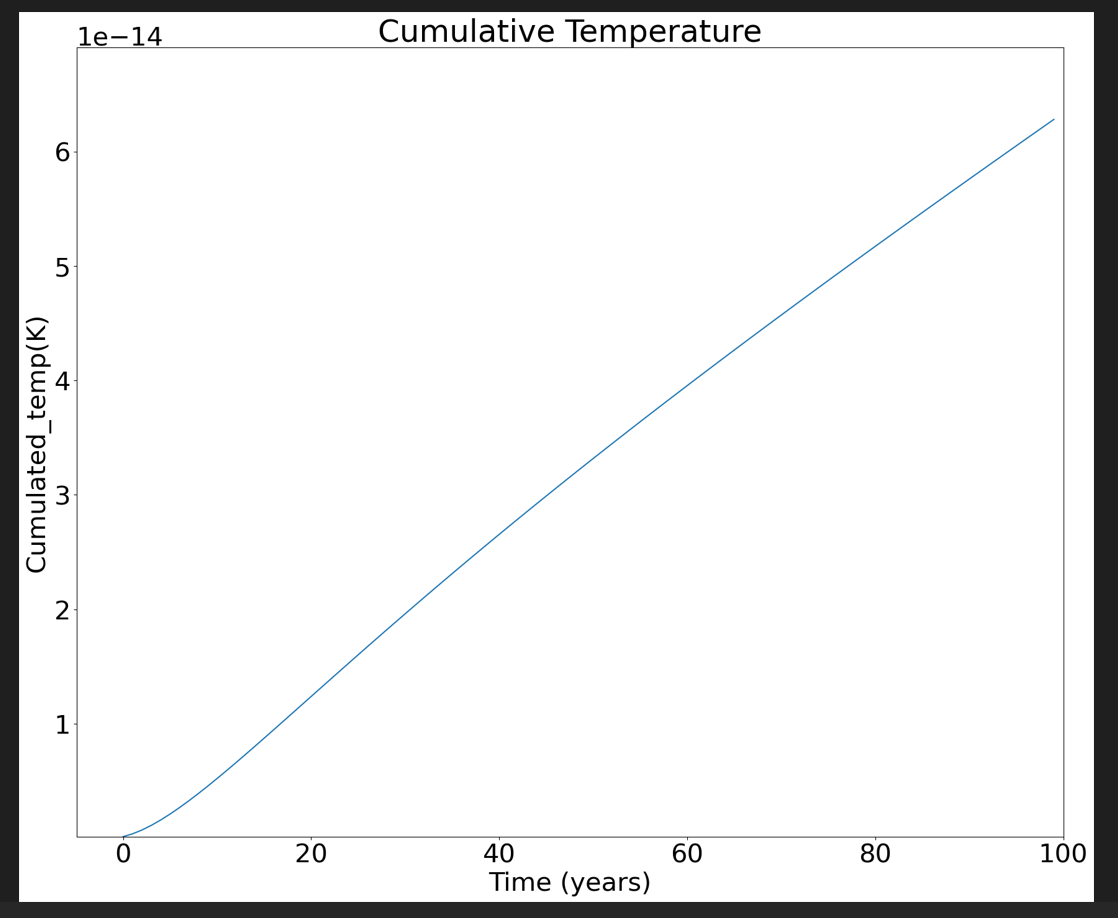

In [ ]:
#tbd what to do with carbon feedback...

def irf_cf(time_points):    
    # Carbon-climate feedback model (impulse response function IRFCF) data from Gasser 2017
    gamma, alpha1, alpha2, alpha3, to1, to2, to3 = 3.015E12, 0.6368, 0.3322, 0.0310, 2.376, 30.14, 490.1  #gamma in kg/(yr K), tau in yr

    
    # DIRAC function
    def DIRAC(t):
        return 1 if t == 0 else 0

    IRFCF = gamma * np.array([DIRAC(t) for t in time_points]) - gamma * ((alpha1/to1) * np.exp(-time_points / to1) + (alpha2/to2) * np.exp(-time_points / to2) + (alpha3/to3) * np.exp(-time_points / to3))
    return IRFCF
    
array_100 = np.arange(0,100,1)
test = irf_cf(array_100)
test



array([ 2.17351767e+12, -5.62805938e+11, -3.79525434e+11, -2.58880654e+11,
       -1.79365109e+11, -1.26860046e+11, -9.20965668e+10, -6.89895731e+10,
       -5.35440557e+10, -4.31370989e+10, -3.60465380e+10, -3.11415359e+10,
       -2.76794543e+10, -2.51725057e+10, -2.33002137e+10, -2.18519451e+10,
       -2.06891843e+10, -1.97207661e+10, -1.88866177e+10, -1.81470847e+10,
       -1.74759237e+10, -1.68557027e+10, -1.62747801e+10, -1.57253228e+10,
       -1.52020032e+10, -1.47011454e+10, -1.42201629e+10, -1.37571906e+10,
       -1.33108420e+10, -1.28800503e+10, -1.24639636e+10, -1.20618762e+10,
       -1.16731828e+10, -1.12973491e+10, -1.09338913e+10, -1.05823638e+10,
       -1.02423496e+10, -9.91345491e+09, -9.59530509e+09, -9.28754168e+09,
       -8.98982064e+09, -8.70181089e+09, -8.42319335e+09, -8.15366007e+09,
       -7.89291368e+09, -7.64066682e+09, -7.39664173e+09, -7.16056985e+09,
       -6.93219147e+09, -6.71125545e+09, -6.49751884e+09, -6.29074667e+09,
       -6.09071165e+09, -